In [63]:
# Purpose of the code:
    # Try to group/cluster the patients
        # Model: K-means clustering
    # Try different classification models other than Random Forest
        # Models: SVM, KNN
        # Validation: 10-fold cross validation

In [64]:
# necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [65]:
# switch to a proper directory to access the data
cd /camdatalake/bronze/verily_ms/device/

/camdatalake/bronze/verily_ms/device


In [66]:
# download and read the data

# FeatureDay: Average value of the features for each day of study. Days are listed as 
# DayOfStudy

# FeatureStudy: Features for the entire study period.For the at home features, 
# the reported value is the median of the observed day level values.

import gzip, csv
with gzip.open("FeaturesDay.csv.gz", "rt", newline="") as file:
    FeatureDay = pd.read_csv(file, header = 0)

with gzip.open("FeaturesStudy.csv.gz", "rt", newline="") as file:
    FeatureStudy = pd.read_csv(file, header = 0)

In [67]:
# explore the datasets
FeatureDay.shape
FeatureStudy.shape

(1532, 217)

(25, 216)

In [68]:
def filter_dataFrame(df):
    # a function to extract the sensor related measurements from the original dataset (df)
    Selected_features = []
    df_columns_names = list(df.columns)
    # patient ID(1 column)
    Selected_features.append('gls_subject_code')
    # related to msfc_composite(3 columns)
    df_columns_MSFC_col_names = []
    for name in df_columns_names:
        name_lowercase = name.lower()
        if 'msfc_composite' in name_lowercase:
            df_columns_MSFC_col_names.append(name)
    # structred activities at home(40 columns)
    df_at_home_col_names = []
    for name in df_columns_names:
        name_lower = name.lower()
        if 'home' in name_lower:
            df_at_home_col_names.append(name)
    # free living features(20 columns)
    # extracted before in Data_Visualization_Part_1_FeatureStudy_Correlation_of_Sensor_Features_to_MSFC.py, and saved
    df_free_living_related = pd.read_csv('FeatureStudy_free_living_related')
    df_free_living_col_names = list(df_free_living_related.columns)
    # add everything to Selected_features list
    Selected_features += list(df_free_living_related.columns)
    Selected_features += df_at_home_col_names
    Selected_features += df_columns_MSFC_col_names
    # return filtered dataframe with selected features
    return df[Selected_features]

In [69]:
def filter_dataFrame_fillna(df):
    # a function to fill null values in the input dataframe (df)
    df_columns_names = list(df.columns)
    # patient ID(1 column)
    df_columns_patientID_col_names =['gls_subject_code']
    df_patientID= df[df_columns_patientID_col_names]
    # related to msfc_composite(3 columns)
    df_columns_MSFC_col_names = []
    for name in df_columns_names:
        name_lowercase = name.lower()
        if 'msfc_composite' in name_lowercase:
            df_columns_MSFC_col_names.append(name)
    df_msfcComposite = df[df_columns_MSFC_col_names]
    # structred activities at home(40 columns)
    df_at_home_col_names = []
    for name in df_columns_names:
        name_lower = name.lower()
        if 'home' in name_lower:
            df_at_home_col_names.append(name)
    df_structuredActivity_atHome = df[df_at_home_col_names]
    # free living features(20 columns)
    df_all_except_freeLiving_col_names = df_columns_patientID_col_names + df_columns_MSFC_col_names + df_at_home_col_names
    df_free_living_col_names = list(set(df_columns_names) - set(df_all_except_freeLiving_col_names))
    df_freeLiving = df[df_free_living_col_names]
    
    # fill null values by row for df_msfcComposite
    for idx in range(len(df_msfcComposite.index)):
        df_msfcComposite.iloc[idx].fillna(df_msfcComposite.iloc[idx].mean(), inplace = True)
    # fill null values by column for df_structuredActivity_atHome
    for col_name in list(df_structuredActivity_atHome.columns):
        df_structuredActivity_atHome[col_name].fillna(df_structuredActivity_atHome[col_name].mean(),inplace= True)
    # fill null values by column for df_freeLiving
    for col_name in list(df_freeLiving.columns):
        df_freeLiving[col_name].fillna(df_freeLiving[col_name].mean(),inplace= True)
    
    # return the updated dataframe with filled null values
    return pd.concat([df_patientID,df_freeLiving,df_structuredActivity_atHome,df_msfcComposite],axis=1)

In [70]:
def remove_rows_with_null(df,TH):
    # a function to remove rows with more than TH% of value points missing
    indexes = []
    count_null = df.isnull().sum(axis=1)
    for idx in range(len(count_null)):
        if count_null[idx] > TH:
            indexes.append(idx)
    df_filtered = df.drop(indexes)
    return df_filtered.reset_index(drop=True)

In [71]:
def remove_columns_with_null(df,TH):
    # a function to remove columns with more than TH% of value points missing
    indexes = []
    count_null = df.isnull().sum()
    col_labels = list(count_null.index)
    for idx in range(len(count_null)):
        if count_null[idx] > TH:
            indexes.append(col_labels[idx])
    df_filtered = df.drop(indexes, axis=1)
    return df_filtered.reset_index(drop=True)

In [72]:
def bin_scores(val,num_of_bins, minimum, maximum):
    # a function to bin the scores
    # input: 
        # val: input value to bin
        # num_of_bins: desired number of bins
        # minimum & maximum: specify the range of values
    # output:
        # binned value
    step = (maximum - minimum)/num_of_bins
    curr_val = minimum
    level = 1
    while(curr_val < maximum):
        curr_val += step
        if val <= curr_val:
            return level
        else:
            level += 1

In [73]:
# extract part of the original dataset which is related to sensor measurements
FeatureStudy_filtered = filter_dataFrame(FeatureStudy)
FeatureDay_filtered = filter_dataFrame(FeatureDay)

In [74]:
#######################################################RESHAPE FEATURESDAY#########################################

In [ ]:
# to consider the time component, we take pair of (feature_value, day_of_study) as a new feature

In [75]:
# check the original dataset
FeatureDay_filtered.head()

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,-1.211435,-1.385647,-1.40763
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,-1.211435,-1.385647,-1.40763
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,-1.211435,-1.385647,-1.40763
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,-1.211435,-1.385647,-1.40763
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,-1.211435,-1.385647,-1.40763


In [76]:
# drop composite scores, we do not have any varoius values for them over days
FeatureDay_filtered_device_features = FeatureDay_filtered.drop(['msfc_composite_1','msfc_composite_2','msfc_composite_3'],axis=1)
FeatureDay_filtered_device_features.head()
FeatureDay_filtered_device_features.shape

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_lr_at_home,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,424.878675,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,460.529853,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,371.773641,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,408.234556,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,380.493350,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555


(1532, 61)

In [77]:
# will need days of study as an index, add to the dataset
FeatureDay_filtered_device_features['dayofstudy'] = FeatureDay['dayofstudy']
FeatureDay_filtered_device_features.head()
FeatureDay_filtered_device_features.shape

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,dayofstudy
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,23
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,34
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,4
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,11
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,15


(1532, 62)

In [78]:
# extract patient IDs
patientIDs = FeatureDay_filtered['gls_subject_code'].unique()
patientIDs

array(['H800001', 'H800002', 'H800003', 'H800004', 'H800006', 'H800007',
       'H800008', 'H800009', 'H800010', 'H800011', 'H800013', 'H800014',
       'H800016', 'H800017', 'H800018', 'H800019', 'H800020', 'H800021',
       'H800022', 'H800023', 'H800024', 'H800025', 'H800005', 'H800012',
       'H800015'], dtype=object)

In [79]:
# what is the maximum number of study days for patients?
num_of_days_of_study = [FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].shape[0] for ID in patientIDs]
days_of_study = pd.DataFrame()
days_of_study['patientID'] = patientIDs
days_of_study['num_of_days'] = num_of_days_of_study
days_of_study.head()
max_num_of_days = max(days_of_study['num_of_days'])

,patientID,num_of_days
0,H800001,62
1,H800002,63
2,H800003,68
3,H800004,65
4,H800006,79


In [80]:
# device features dataset + patient IDs + day of study + composite scores
FeatureDay_filtered_device_features.head()

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,dayofstudy
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,23
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,34
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,4
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,11
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,15


In [81]:
# just keep the sensor features 
device_feature_names = list(FeatureDay_filtered_device_features.drop(['gls_subject_code','dayofstudy'],axis = 1))
len(device_feature_names)

60

In [82]:
# transform the dataset, add feature values for each day as a new column
final_df = pd.DataFrame()
for ID in patientIDs:
    print(ID)
    arr = ID.split('0')
    sub_df = FeatureDay_filtered_device_features[FeatureDay_filtered_device_features['gls_subject_code'] == ID]
    new_df = pd.DataFrame()
    new_df['gls_subject_code'] = [ID]
    for day in np.arange(1,max_num_of_days + 1):
        for feature in device_feature_names:
            col_name = feature + '_day_' + str(day)
            if day in sub_df['dayofstudy'].tolist():
                idx = sub_df['dayofstudy'].tolist().index(23)
                val = sub_df.iloc[idx][feature]
                new_df[col_name] = [val]
            else:
                new_df[col_name] = [np.nan]
    final_df = pd.concat([final_df,new_df])

H800001
H800002
H800003
H800004
H800006
H800007
H800008
H800009
H800010
H800011
H800013
H800014
H800016
H800017
H800018
H800019
H800020
H800021
H800022
H800023
H800024
H800025
H800005
H800012
H800015


In [83]:
# check the transformed dataframe
final_df.head()
final_df.shape

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,sway_disp_lr_at_home_day_80,sway_disp_ap_at_home_day_80,mobility_activity_at_home_time_day_80,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(25, 4801)

In [84]:
# add back patient IDs + composite scores to the transformed dataset
msfc_composite_1 = []
msfc_composite_2 = []
msfc_composite_3 = []
for ID in final_df['gls_subject_code']:
    msfc_composite_1.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_1'])
    msfc_composite_2.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_2'])
    msfc_composite_3.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_3'])
final_df['msfc_composite_1'] = msfc_composite_1
final_df['msfc_composite_2'] = msfc_composite_2
final_df['msfc_composite_3'] = msfc_composite_3
final_df.head()

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.211435,-1.385647,-1.407630
0,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389599,1.109154,0.631568
0,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780895,0.932657,0.911542
0,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.969236,-0.983236,-0.695738
0,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245690,0.568276,0.495086


In [85]:
# fix the index of the transformed dataset
FeatureDay_filtered_reshaped = final_df.reset_index(drop=True)
FeatureDay_filtered_reshaped.head()

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.211435,-1.385647,-1.407630
1,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389599,1.109154,0.631568
2,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780895,0.932657,0.911542
3,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.969236,-0.983236,-0.695738
4,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245690,0.568276,0.495086


In [86]:
###################################################END OF REASHAPING FEATUREDAY####################################

In [87]:
# preprocessing: remove columns, rows with > 50% null values

# featureStudy
# columns
TH = FeatureStudy_filtered.shape[0]/2
FeatureStudy_filtered_nullDropped = remove_columns_with_null(FeatureStudy_filtered, TH)
# rows
TH = FeatureStudy_filtered.shape[1]/2
FeatureStudy_filtered_nullDropped = remove_rows_with_null(FeatureStudy_filtered_nullDropped, TH)

# featureDay
# columns
TH = FeatureDay_filtered_reshaped.shape[0]/2
FeatureDay_filtered_reshaped_nullDropped = remove_columns_with_null(FeatureDay_filtered_reshaped, TH)
# rows
TH = FeatureDay_filtered_reshaped_nullDropped.shape[1]/2
FeatureDay_filtered_reshaped_nullDropped = remove_rows_with_null(FeatureDay_filtered_reshaped_nullDropped, TH)

# compare shapes of new dataframes with original ones
FeatureStudy_filtered.shape
FeatureStudy_filtered_nullDropped.shape
FeatureDay_filtered_reshaped.shape
FeatureDay_filtered_reshaped_nullDropped.shape

(25, 64)

(22, 64)

(25, 4804)

(20, 1830)

In [88]:
# preprocessing: fill null values
# msfc composite scores: mean on row
# feature values: mean on columns
df_study = filter_dataFrame_fillna(FeatureStudy_filtered_nullDropped)
df_day = filter_dataFrame_fillna(FeatureDay_filtered_reshaped_nullDropped)

/opt/python3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [89]:
# check to make sure there is no null value left
df_day.shape
df_day.isnull().sum().sum()
df_study.shape
df_study.isnull().sum().sum()

(20, 1830)

0

(22, 64)

0

In [90]:
# removed patients
set(patientIDs) - set(df_day['gls_subject_code'])
set(patientIDs) - set(df_study['gls_subject_code'])

{'H800002', 'H800005', 'H800009', 'H800012', 'H800015'}

{'H800005', 'H800012', 'H800015'}

In [91]:
# data engineering: add binned-msfc3 scores to the dataset
num_of_bins = 3
minimum =  df_study['msfc_composite_3'].min()
maximum = df_study['msfc_composite_3'].max()
df_study['msfc_composite_3_bin'] = df_study['msfc_composite_3'].apply(bin_scores, args=(num_of_bins, minimum, maximum))

num_of_bins = 3
minimum =  df_day['msfc_composite_3'].min()
maximum = df_day['msfc_composite_3'].max()
df_day['msfc_composite_3_bin'] = df_day['msfc_composite_3'].apply(bin_scores, args=(num_of_bins, minimum, maximum))

In [92]:
# prepare x,y
# df_study
col_names_potential_targets = ['msfc_composite_1', 'msfc_composite_2', 'msfc_composite_3']
remove_cols = col_names_potential_targets.append('gls_subject_code')
# training data (X)
x_study = df_study.drop(col_names_potential_targets,axis=1)
# training data (Y)
y_study = df_study['msfc_composite_3']

In [93]:
# prepare x,y
# df_day
col_names_potential_targets = ['msfc_composite_1', 'msfc_composite_2', 'msfc_composite_3']
remove_cols = col_names_potential_targets.append('gls_subject_code')
# training data (X)
x_day = df_day.drop(col_names_potential_targets,axis=1)
# training data (Y)
y_day = df_day['msfc_composite_3']

In [94]:
# k-means clustering with PCA
def K_means_with_PCA(x,y,bin_num,PC_num):
    # normalize the data
    x_normalized = (x - x.mean()) / (x.max() - x.min())
    
    # bin the traget
    minimum =  y.min()
    maximum = y.max()
    y_binned = y.apply(bin_scores, args=(bin_num, minimum, maximum))
    
    # PCA transformation
    from sklearn.decomposition import PCA
    pca = PCA(n_components=PC_num)
    pca.fit(x_normalized)
    x_pca = pca.transform(x_normalized)
    x_pca_df = pd.DataFrame(x_pca)
    
    # K-means clustering
    from sklearn.cluster import KMeans
    kMeans = KMeans(n_clusters=bin_num, random_state=101)
    KM = kMeans.fit(x_pca_df)
    predictions = KM.labels_
    
    # Compare the predicted labels with actual ones
    fig, axes = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=(10,5))
    axes[0].scatter(x_pca_df[0], x_pca_df[1], c=y_binned, cmap='rainbow')
    axes[0].set_title('original')
    axes[1].scatter(x_pca_df[0], x_pca_df[1],c=predictions,cmap='rainbow')
    axes[1].set_title('K Means')

In [95]:
np.arange(2,3)

array([2])

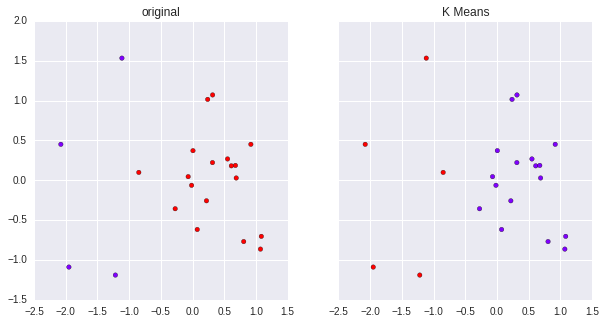

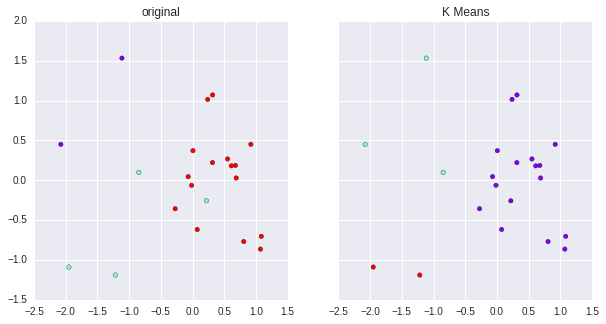

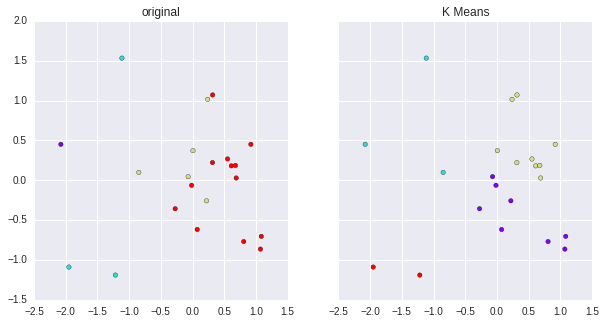

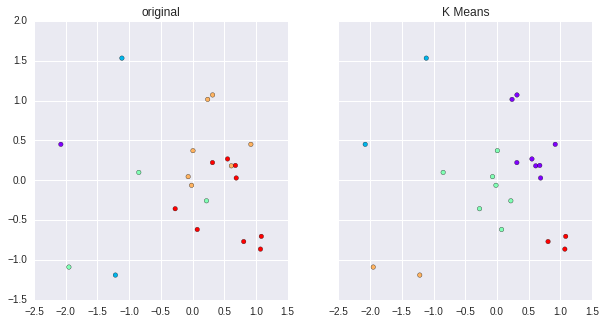

In [96]:
# FeatureStudy
# PC_num = 2, make it possible to visualize the clusters
# try different number of bins (clusters)
for bin_num in np.arange(2,6):
    K_means_with_PCA(x_study, y_study, bin_num, 2)
    
# results show with more than 3 levels for MSFC scores, the clustering does not work well.

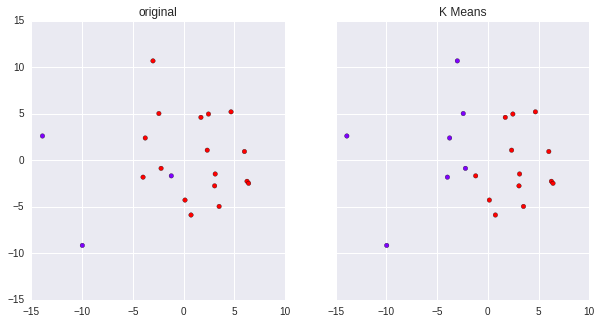

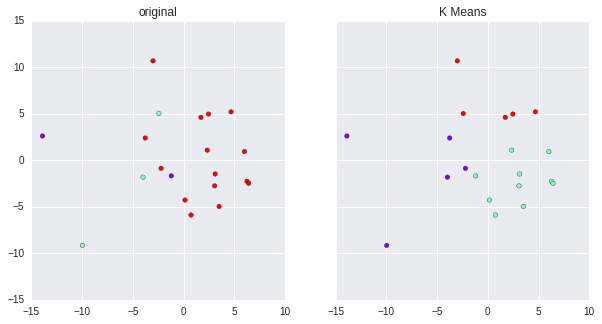

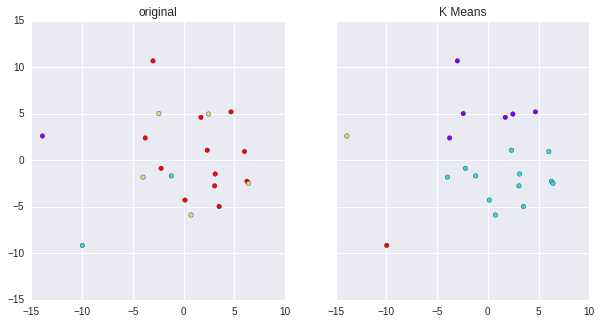

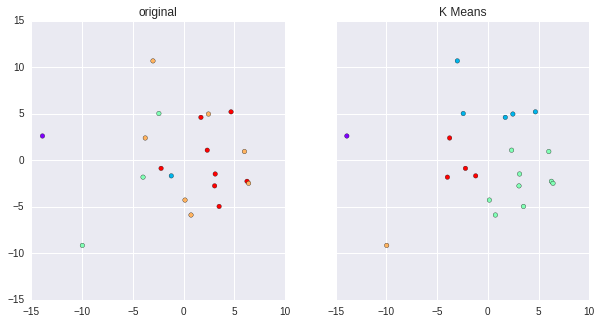

In [97]:
# FeatureDay
# PC_num = 2, make it possible to visualize the clusters
# try different number of bins (clusters)
for bin_num in np.arange(2,6):
    K_means_with_PCA(x_day, y_day, bin_num, 2)

In [98]:
# k-means clustering with feature selection
def K_means_with_feature_selection(x, y, bin_num, n_features_to_select, n_clusters):
    # bin the traget
    bin_num = bin_num
    minimum =  y.min()
    maximum = y.max()
    y_binned = y.apply(bin_scores, args=(bin_num, minimum, maximum))

    # Feature selectoin using wrapper methods
    from sklearn.feature_selection import RFE, RFECV
    from sklearn.ensemble import RandomForestClassifier
    n_features_to_select = n_features_to_select
    rf = RandomForestClassifier()
    ref = RFE(rf, n_features_to_select=n_features_to_select)
    fit = ref.fit(x, y_binned)

    # check the selected features
    selected_features = []
    for idx in range(len(list(x.columns))):
        if fit.support_[idx] == True:
            selected_features.append(list(x.columns)[idx])

    # k-means using the selected features
    x = x[selected_features]

    # normalize the data
    x = (x - x.mean()) / (x.max() - x.min())

    # K-means clustering
    from sklearn.cluster import KMeans
    n_clusters = n_clusters
    kMeans = KMeans(n_clusters=n_clusters, random_state=101)
    KM = kMeans.fit(x)
    predictions = KM.labels_

    # Compare the predicted labels with actual ones
    f1 = selected_features[0]
    f2 = selected_features[1]
    fig, axes = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=(10,5))
    axes[0].scatter(x[f1], x[f2], c=y_binned, cmap='rainbow')
    axes[0].set_title('original')
    axes[0].set_xlabel(f1)
    axes[0].set_ylabel(f2)

    axes[1].scatter(x[f1], x[f2],c=predictions,cmap='rainbow')
    axes[1].set_title('K Means')
    axes[1].set_xlabel(f1)
    axes[1].set_ylabel(f2)

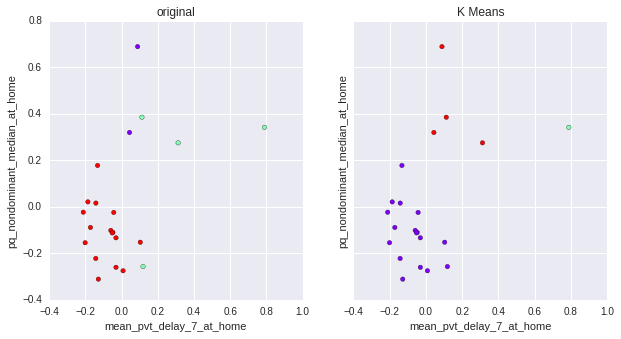

In [99]:
# FeatureStudy
# bin_num = 3
# n_features_to_select = 2
# n_clusters = 3
K_means_with_feature_selection(x_study, y_study, 3, 2, 3)

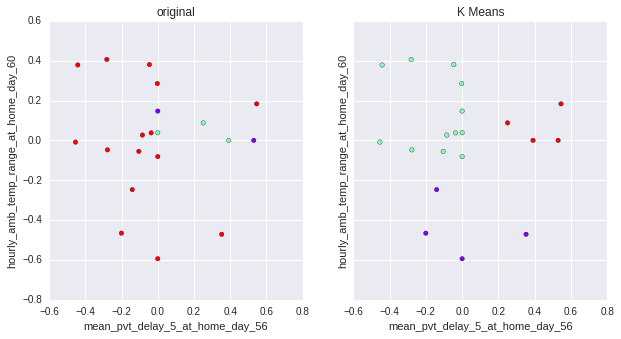

In [100]:
# FeatureDay
# bin_num = 3
# n_features_to_select = 2
# n_clusters = 3
K_means_with_feature_selection(x_day, y_day, 3, 2, 3)

In [101]:
# results show, FeatureDay does not work well with the clustering.
# FeatureStudy results in better cluster predictions 

In [102]:
# try different models for classification

In [103]:
# KNN, KFCV
def KNN(x,y,bin_num,n_folds,n_neighbors):
    # bin the traget
    bin_num = bin_num
    minimum =  y.min()
    maximum = y.max()
    y_binned = y.apply(bin_scores, args=(bin_num, minimum, maximum))
    # scale the data 
    from sklearn.preprocessing import StandardScaler
    StandardScaler =  StandardScaler()
    StandardScaler.fit(x)
    x_scaled = StandardScaler.transform(x)
    x_scaled = pd.DataFrame(x_scaled,columns=list(x.columns))
    # K=10 fold cross validation
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
    from sklearn.cross_validation import KFold
    kf = KFold(len(y_binned),n_folds=n_folds,random_state=101)
    accuracy_scores = []
    for train_index, test_index in kf:
        x_train, x_test = x_scaled.iloc[train_index],x_scaled.iloc[test_index]
        y_train, y_test = y_binned.iloc[train_index], y_binned.iloc[test_index]
        # train the model
        KNN = KNeighborsClassifier(n_neighbors=n_neighbors)
        KNN.fit(x_train,y_train)
        predictions = KNN.predict(x_test)
        # evaluate the model
        accuracy_scores.append(accuracy_score(y_test,predictions))
        # print(classification_report(y_test,predictions))
    return np.mean(accuracy_scores)

/opt/python3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


0.816666666667


/opt/python3/lib/python3.5/site-packages/sklearn/neighbors/base.py:378: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  neigh_ind = neigh_ind[:, :n_neighbors]


(0, 1)

(1, 12.0)

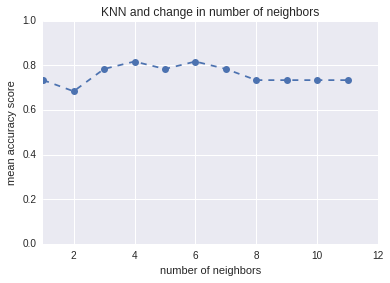

In [104]:
# FeatureStudy
bin_num = 3
n_folds = 10
scores = []
# try different number of neighbors in KNN
for n_neighbors in np.arange(1,len(y_study)/2+1):
    scores.append(KNN(x_study,y_study,bin_num,n_folds,n_neighbors))
# maximum mean score
print(np.max(scores))
# plot the relation between change of number of neighbors and mean accuracy score
plt.plot(np.arange(1,len(y_study)/2+1),scores,marker = 'o',ls='--')
plt.ylim((0,1))
plt.xlim((1,len(y_study)/2+1))
plt.xlabel('number of neighbors')
plt.ylabel('mean accuracy score')
plt.title('KNN and change in number of neighbors')

/opt/python3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/opt/python3/lib/python3.5/site-packages/sklearn/neighbors/base.py:378: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  neigh_ind = neigh_ind[:, :n_neighbors]


0.75


(0, 1)

(1, 11.0)

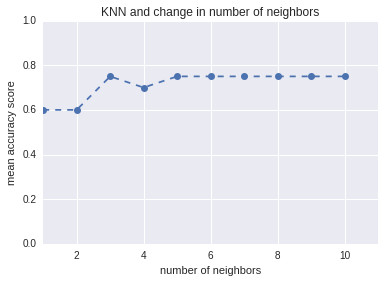

In [105]:
# FeatureDay
bin_num = 3
n_folds = 10
scores = []
# try different number of neighbors in KNN
for n_neighbors in np.arange(1,len(y_day)/2+1):
    scores.append(KNN(x_day,y_day,bin_num,n_folds,n_neighbors))
# maximum mean score
print(np.max(scores))
# plot the relation between change of number of neighbors and mean accuracy score
plt.plot(np.arange(1,len(y_day)/2+1),scores,marker = 'o',ls='--')
plt.xlabel('number of neighbors')
plt.ylabel('mean accuracy score')
plt.title('KNN and change in number of neighbors')
plt.ylim((0,1))
plt.xlim((1,len(y_day)/2+1))

In [106]:
# results: 
# FeatureStudy: MAS = 0.81, num_neighbors = 4
# FeatureDay: MAS = 0.75, num_neighbors = 3

In [107]:
# SVM

In [108]:
# SVM, KFCV
def SVM(x,y,bin_num,n_folds,kernel,c,gamma):
    # bin the traget
    bin_num = bin_num
    minimum =  y.min()
    maximum = y.max()
    y_binned = y.apply(bin_scores, args=(bin_num, minimum, maximum))
    # scale the data 
    from sklearn.preprocessing import StandardScaler
    StandardScaler =  StandardScaler()
    StandardScaler.fit(x)
    x_scaled = StandardScaler.transform(x)
    x_scaled = pd.DataFrame(x_scaled,columns=list(x.columns))
    # K=10 fold cross validation
    from sklearn.svm import SVC
    from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
    from sklearn.cross_validation import KFold
    kf = KFold(len(y_binned),n_folds=n_folds,random_state=101)
    accuracy_scores = []
    for train_index, test_index in kf:
        x_train, x_test = x_scaled.iloc[train_index],x_scaled.iloc[test_index]
        y_train, y_test = y_binned.iloc[train_index], y_binned.iloc[test_index]
        # train the model
        svm = SVC(kernel=kernel,C=c,gamma=gamma)
        svm.fit(x_train,y_train)
        predictions = svm.predict(x_test)
        # evaluate the model
        accuracy_scores.append(accuracy_score(y_test,predictions))
        #print(classification_report(y_test,predictions))
    return np.mean(accuracy_scores)

In [124]:
# FeatureStudy
bin_num = 3
n_folds = 10
kernel = 'rbf'
scores = []
# do a grid search to pick the best c(regularization) and gamma(kernel coefficient) to train svm
for c in np.linspace(0.1,2,10):
    for gamma in np.linspace(0.001,1,100):
        scores.append((SVM(x_study,y_study,bin_num,n_folds,kernel,c, gamma),c,gamma))
        
# maximum mean score
accuracy = []
for (score,c,gamma) in scores:
    accuracy.append(score)
np.max(accuracy)

0.78333333333333333

In [125]:
# FeatureDay
bin_num = 3
n_folds = 10
kernel = 'rbf'
scores = []
# do a grid search to pick the best c(regularization) and gamma(kernel coefficient) to train svm
for c in np.linspace(0.1,2,10):
    for gamma in np.linspace(0.001,1,100):
        scores.append((SVM(x_day,y_day,bin_num,n_folds,kernel,c, gamma),c,gamma))

# maximum mean score
accuracy = []
for (score,c,gamma) in scores:
    accuracy.append(score)
np.max(accuracy)

0.75